In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html


In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 356 (delta 165), reused 279 (delta 91), pack-reused 0
Receiving objects: 100% (356/356), 38.13 MiB | 15.64 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6054, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 6054 (delta 295), reused 308 (delta 172), pack-reused 5494
Receiving objects: 100% (6054/6054), 12.60 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (4364/4364), done.
Note: checking out '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [5]:
!rm -rf segmentation/
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image020-roi1.tif  
  inflating: segmentation/annotations/image008-roi1.tif  
  inflating: segmentation/annotations/image032-roi1.tif  
  inflating: segmentation/annotations/image019-roi2.tif  
  inflating: segmentation/annotations/image019-roi5.tif  
  inflating: segmentation/annotations/image058-roi5.tif  
  inflating: segmentation/annotations/image038-roi4.tif  
  inflating: segmentation/annotations/image058-roi1.tif  
  inflating: segmentation/annotations/image021-roi3.tif  
  inflating: segmentation/annotations/image006-roi2.tif  
  inflating: segmentation/annotations/image021-roi6.tif  
  inflating: segmentation/annotations/image038-roi1.tif  
  inflating: segmentation/annotations/image003-2-roi3.tif  
  inflating: segmentation/annotations/image038-roi3.tif  
  inflating: segmentation/annotations/image039-roi3.tif  
  inflating: segmentation/ann

In [6]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

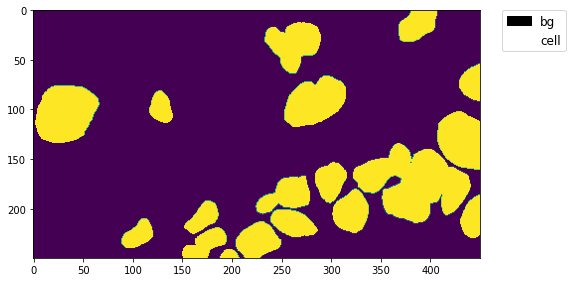

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/pspnet.py')

In [12]:
cfg.runner.max_epochs = 50
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-02-16 23:29:58,201 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

/content/tcc/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-02-16 23:30:01,309 - mmseg - INFO - Loaded 24 images
2022-02-16 23:30:01,312 - mmseg - INFO - Start running, host: root@a2bcbd0dd228, work_dir: /content/tcc/mmsegmentation/work_dirs/psp
2022-02-16 23:30:01,315 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.9 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:30:23,666 - mmseg - INFO - per class results:
2022-02-16 23:30:23,670 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.77 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-02-16 23:30:23,672 - mmseg - INFO - Summary:
2022-02-16 23:30:23,674 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 67.74 | 40.38 | 50.0 |
+-------+-------+------+
2022-02-16 23:30:23,678 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.6774, mDice: 0.4038, mAcc: 0.5000, Dice.bg: 0.8077, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-02-16 23:30:42,316 - mmseg - INFO - Epoch [2][12/12]	lr: 9.822e-03, eta: 0:15:03, time: 1.541, data_time: 0.192, memory: 3768, decode.loss_ce: 0.5168, decode.acc_seg: 52.9117, aux.loss_ce: 0.2060, aux.acc_seg: 53.7257, loss: 0.7228


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:30:44,478 - mmseg - INFO - per class results:
2022-02-16 23:30:44,479 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.79 |  95.9 |
|  cell | 21.14 | 12.84 |
+-------+-------+-------+
2022-02-16 23:30:44,484 - mmseg - INFO - Summary:
2022-02-16 23:30:44,487 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 69.11 | 50.96 | 54.37 |
+-------+-------+-------+
2022-02-16 23:30:44,489 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.6911, mDice: 0.5096, mAcc: 0.5437, Dice.bg: 0.8079, Dice.cell: 0.2114, Acc.bg: 0.9590, Acc.cell: 0.1284
2022-02-16 23:31:03,050 - mmseg - INFO - Epoch [3][12/12]	lr: 9.643e-03, eta: 0:14:38, time: 1.535, data_time: 0.190, memory: 3768, decode.loss_ce: 0.4751, decode.acc_seg: 52.2184, aux.loss_ce: 0.1886, aux.acc_seg: 52.6196, loss: 0.6637


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:31:05,214 - mmseg - INFO - per class results:
2022-02-16 23:31:05,216 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 79.34 | 87.32 |
|  cell | 39.44 | 31.11 |
+-------+-------+-------+
2022-02-16 23:31:05,221 - mmseg - INFO - Summary:
2022-02-16 23:31:05,223 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 69.19 | 59.39 | 59.21 |
+-------+-------+-------+
2022-02-16 23:31:05,225 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.6919, mDice: 0.5939, mAcc: 0.5921, Dice.bg: 0.7934, Dice.cell: 0.3944, Acc.bg: 0.8732, Acc.cell: 0.3111
2022-02-16 23:31:23,770 - mmseg - INFO - Epoch [4][12/12]	lr: 9.464e-03, eta: 0:14:16, time: 1.534, data_time: 0.191, memory: 3768, decode.loss_ce: 0.4422, decode.acc_seg: 52.4612, aux.loss_ce: 0.1773, aux.acc_seg: 52.6374, loss: 0.6196


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:31:25,962 - mmseg - INFO - per class results:
2022-02-16 23:31:25,965 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.88 | 87.48 |
|  cell | 47.58 | 39.42 |
+-------+-------+-------+
2022-02-16 23:31:25,969 - mmseg - INFO - Summary:
2022-02-16 23:31:25,971 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 71.98 | 64.23 | 63.45 |
+-------+-------+-------+
2022-02-16 23:31:25,974 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7198, mDice: 0.6423, mAcc: 0.6345, Dice.bg: 0.8088, Dice.cell: 0.4758, Acc.bg: 0.8748, Acc.cell: 0.3942
2022-02-16 23:31:44,503 - mmseg - INFO - Epoch [5][12/12]	lr: 9.284e-03, eta: 0:13:55, time: 1.532, data_time: 0.187, memory: 3768, decode.loss_ce: 0.4559, decode.acc_seg: 58.0013, aux.loss_ce: 0.1824, aux.acc_seg: 58.1260, loss: 0.6383


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:31:46,685 - mmseg - INFO - per class results:
2022-02-16 23:31:46,687 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.82 | 83.33 |
|  cell |  55.6 | 51.98 |
+-------+-------+-------+
2022-02-16 23:31:46,689 - mmseg - INFO - Summary:
2022-02-16 23:31:46,698 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 73.22 | 68.21 | 67.65 |
+-------+-------+-------+
2022-02-16 23:31:46,701 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.7322, mDice: 0.6821, mAcc: 0.6765, Dice.bg: 0.8082, Dice.cell: 0.5560, Acc.bg: 0.8333, Acc.cell: 0.5198
2022-02-16 23:32:05,255 - mmseg - INFO - Epoch [6][12/12]	lr: 9.104e-03, eta: 0:13:35, time: 1.534, data_time: 0.194, memory: 3768, decode.loss_ce: 0.4000, decode.acc_seg: 55.7056, aux.loss_ce: 0.1585, aux.acc_seg: 56.0060, loss: 0.5585


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:32:07,438 - mmseg - INFO - per class results:
2022-02-16 23:32:07,443 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 79.61 | 77.41 |
|  cell | 60.64 | 64.16 |
+-------+-------+-------+
2022-02-16 23:32:07,448 - mmseg - INFO - Summary:
2022-02-16 23:32:07,451 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 73.14 | 70.13 | 70.78 |
+-------+-------+-------+
2022-02-16 23:32:07,454 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.7314, mDice: 0.7013, mAcc: 0.7078, Dice.bg: 0.7961, Dice.cell: 0.6064, Acc.bg: 0.7741, Acc.cell: 0.6416
2022-02-16 23:32:26,071 - mmseg - INFO - Epoch [7][12/12]	lr: 8.924e-03, eta: 0:13:16, time: 1.540, data_time: 0.198, memory: 3768, decode.loss_ce: 0.4050, decode.acc_seg: 58.2792, aux.loss_ce: 0.1640, aux.acc_seg: 57.8653, loss: 0.5690


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:32:28,254 - mmseg - INFO - per class results:
2022-02-16 23:32:28,258 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.46 | 83.42 |
|  cell |  61.8 | 60.29 |
+-------+-------+-------+
2022-02-16 23:32:28,261 - mmseg - INFO - Summary:
2022-02-16 23:32:28,265 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 75.96 | 72.13 | 71.85 |
+-------+-------+-------+
2022-02-16 23:32:28,268 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.7596, mDice: 0.7213, mAcc: 0.7185, Dice.bg: 0.8246, Dice.cell: 0.6180, Acc.bg: 0.8342, Acc.cell: 0.6029
2022-02-16 23:32:47,058 - mmseg - INFO - Epoch [8][12/12]	lr: 8.743e-03, eta: 0:12:59, time: 1.554, data_time: 0.212, memory: 3768, decode.loss_ce: 0.4046, decode.acc_seg: 58.1487, aux.loss_ce: 0.1633, aux.acc_seg: 57.9974, loss: 0.5680


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:32:49,248 - mmseg - INFO - per class results:
2022-02-16 23:32:49,252 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.67 | 89.23 |
|  cell | 57.51 | 49.48 |
+-------+-------+-------+
2022-02-16 23:32:49,253 - mmseg - INFO - Summary:
2022-02-16 23:32:49,260 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.41 | 70.59 | 69.36 |
+-------+-------+-------+
2022-02-16 23:32:49,261 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.7641, mDice: 0.7059, mAcc: 0.6936, Dice.bg: 0.8367, Dice.cell: 0.5751, Acc.bg: 0.8923, Acc.cell: 0.4948
2022-02-16 23:33:07,807 - mmseg - INFO - Epoch [9][12/12]	lr: 8.562e-03, eta: 0:12:39, time: 1.534, data_time: 0.191, memory: 3768, decode.loss_ce: 0.4132, decode.acc_seg: 62.9263, aux.loss_ce: 0.1678, aux.acc_seg: 62.5721, loss: 0.5810


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:33:09,978 - mmseg - INFO - per class results:
2022-02-16 23:33:09,983 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.67 | 86.88 |
|  cell | 61.26 | 56.33 |
+-------+-------+-------+
2022-02-16 23:33:09,984 - mmseg - INFO - Summary:
2022-02-16 23:33:09,997 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 77.02 | 72.47 | 71.6 |
+-------+-------+------+
2022-02-16 23:33:09,998 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.7702, mDice: 0.7247, mAcc: 0.7160, Dice.bg: 0.8367, Dice.cell: 0.6126, Acc.bg: 0.8688, Acc.cell: 0.5633
2022-02-16 23:33:28,523 - mmseg - INFO - Epoch [10][12/12]	lr: 8.381e-03, eta: 0:12:20, time: 1.532, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3865, decode.acc_seg: 56.9120, aux.loss_ce: 0.1561, aux.acc_seg: 56.7176, loss: 0.5426
2022-02-16 23:33:28,527 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.3 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:33:33,428 - mmseg - INFO - per class results:
2022-02-16 23:33:33,431 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.76 | 86.83 |
|  cell | 61.68 | 56.92 |
+-------+-------+-------+
2022-02-16 23:33:33,432 - mmseg - INFO - Summary:
2022-02-16 23:33:33,436 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.18 | 72.72 | 71.88 |
+-------+-------+-------+
2022-02-16 23:33:33,439 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.7718, mDice: 0.7272, mAcc: 0.7188, Dice.bg: 0.8376, Dice.cell: 0.6168, Acc.bg: 0.8683, Acc.cell: 0.5692
2022-02-16 23:33:51,931 - mmseg - INFO - Epoch [11][12/12]	lr: 8.199e-03, eta: 0:12:01, time: 1.529, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3840, decode.acc_seg: 64.0071, aux.loss_ce: 0.1585, aux.acc_seg: 63.2774, loss: 0.5424


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:33:54,124 - mmseg - INFO - per class results:
2022-02-16 23:33:54,127 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.59 | 87.67 |
|  cell | 63.68 | 58.81 |
+-------+-------+-------+
2022-02-16 23:33:54,130 - mmseg - INFO - Summary:
2022-02-16 23:33:54,137 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.36 | 74.13 | 73.24 |
+-------+-------+-------+
2022-02-16 23:33:54,141 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.7836, mDice: 0.7413, mAcc: 0.7324, Dice.bg: 0.8459, Dice.cell: 0.6368, Acc.bg: 0.8767, Acc.cell: 0.5881
2022-02-16 23:34:12,661 - mmseg - INFO - Epoch [12][12/12]	lr: 8.016e-03, eta: 0:11:42, time: 1.532, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3764, decode.acc_seg: 60.5697, aux.loss_ce: 0.1536, aux.acc_seg: 60.2983, loss: 0.5301


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.1 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:34:14,826 - mmseg - INFO - per class results:
2022-02-16 23:34:14,829 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.67 | 82.92 |
|  cell | 66.65 | 67.91 |
+-------+-------+-------+
2022-02-16 23:34:14,831 - mmseg - INFO - Summary:
2022-02-16 23:34:14,834 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.07 | 75.16 | 75.41 |
+-------+-------+-------+
2022-02-16 23:34:14,841 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.7807, mDice: 0.7516, mAcc: 0.7541, Dice.bg: 0.8367, Dice.cell: 0.6665, Acc.bg: 0.8292, Acc.cell: 0.6791
2022-02-16 23:34:33,368 - mmseg - INFO - Epoch [13][12/12]	lr: 7.833e-03, eta: 0:11:23, time: 1.532, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3842, decode.acc_seg: 62.1769, aux.loss_ce: 0.1580, aux.acc_seg: 61.4243, loss: 0.5422


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:34:35,559 - mmseg - INFO - per class results:
2022-02-16 23:34:35,563 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.66 | 80.78 |
|  cell | 66.04 | 69.19 |
+-------+-------+-------+
2022-02-16 23:34:35,565 - mmseg - INFO - Summary:
2022-02-16 23:34:35,573 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.04 | 74.35 | 74.98 |
+-------+-------+-------+
2022-02-16 23:34:35,576 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.7704, mDice: 0.7435, mAcc: 0.7498, Dice.bg: 0.8266, Dice.cell: 0.6604, Acc.bg: 0.8078, Acc.cell: 0.6919
2022-02-16 23:34:54,025 - mmseg - INFO - Epoch [14][12/12]	lr: 7.650e-03, eta: 0:11:04, time: 1.526, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3959, decode.acc_seg: 65.3404, aux.loss_ce: 0.1590, aux.acc_seg: 65.1271, loss: 0.5549


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:34:56,213 - mmseg - INFO - per class results:
2022-02-16 23:34:56,217 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.21 | 84.16 |
|  cell | 66.91 | 67.01 |
+-------+-------+-------+
2022-02-16 23:34:56,218 - mmseg - INFO - Summary:
2022-02-16 23:34:56,224 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.63 | 75.56 | 75.58 |
+-------+-------+-------+
2022-02-16 23:34:56,228 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.7863, mDice: 0.7556, mAcc: 0.7558, Dice.bg: 0.8421, Dice.cell: 0.6691, Acc.bg: 0.8416, Acc.cell: 0.6701
2022-02-16 23:35:14,861 - mmseg - INFO - Epoch [15][12/12]	lr: 7.466e-03, eta: 0:10:46, time: 1.541, data_time: 0.198, memory: 3768, decode.loss_ce: 0.3377, decode.acc_seg: 57.6540, aux.loss_ce: 0.1394, aux.acc_seg: 57.1009, loss: 0.4771


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:35:17,051 - mmseg - INFO - per class results:
2022-02-16 23:35:17,054 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.96 | 84.63 |
|  cell | 65.45 | 64.34 |
+-------+-------+-------+
2022-02-16 23:35:17,056 - mmseg - INFO - Summary:
2022-02-16 23:35:17,065 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.09 |  74.7 | 74.49 |
+-------+-------+-------+
2022-02-16 23:35:17,066 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.7809, mDice: 0.7470, mAcc: 0.7449, Dice.bg: 0.8396, Dice.cell: 0.6545, Acc.bg: 0.8463, Acc.cell: 0.6434
2022-02-16 23:35:35,599 - mmseg - INFO - Epoch [16][12/12]	lr: 7.282e-03, eta: 0:10:27, time: 1.532, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3613, decode.acc_seg: 60.4360, aux.loss_ce: 0.1462, aux.acc_seg: 60.1635, loss: 0.5075


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:35:37,801 - mmseg - INFO - per class results:
2022-02-16 23:35:37,803 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.15 | 90.39 |
|  cell | 61.99 | 53.99 |
+-------+-------+-------+
2022-02-16 23:35:37,804 - mmseg - INFO - Summary:
2022-02-16 23:35:37,807 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.64 | 73.57 | 72.19 |
+-------+-------+-------+
2022-02-16 23:35:37,812 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.7864, mDice: 0.7357, mAcc: 0.7219, Dice.bg: 0.8515, Dice.cell: 0.6199, Acc.bg: 0.9039, Acc.cell: 0.5399
2022-02-16 23:35:56,373 - mmseg - INFO - Epoch [17][12/12]	lr: 7.097e-03, eta: 0:10:09, time: 1.535, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3671, decode.acc_seg: 61.9720, aux.loss_ce: 0.1492, aux.acc_seg: 61.5349, loss: 0.5164


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:35:58,575 - mmseg - INFO - per class results:
2022-02-16 23:35:58,577 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.01 | 88.88 |
|  cell | 63.61 | 57.53 |
+-------+-------+-------+
2022-02-16 23:35:58,580 - mmseg - INFO - Summary:
2022-02-16 23:35:58,584 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.76 | 74.31 | 73.2 |
+-------+-------+------+
2022-02-16 23:35:58,587 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.7876, mDice: 0.7431, mAcc: 0.7320, Dice.bg: 0.8501, Dice.cell: 0.6361, Acc.bg: 0.8888, Acc.cell: 0.5753
2022-02-16 23:36:17,164 - mmseg - INFO - Epoch [18][12/12]	lr: 6.911e-03, eta: 0:09:50, time: 1.536, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3560, decode.acc_seg: 61.2133, aux.loss_ce: 0.1418, aux.acc_seg: 61.3616, loss: 0.4978


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:36:19,364 - mmseg - INFO - per class results:
2022-02-16 23:36:19,368 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.61 | 88.75 |
|  cell | 66.05 | 60.97 |
+-------+-------+-------+
2022-02-16 23:36:19,370 - mmseg - INFO - Summary:
2022-02-16 23:36:19,372 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.79 | 75.83 | 74.86 |
+-------+-------+-------+
2022-02-16 23:36:19,374 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.7979, mDice: 0.7583, mAcc: 0.7486, Dice.bg: 0.8561, Dice.cell: 0.6605, Acc.bg: 0.8875, Acc.cell: 0.6097
2022-02-16 23:36:38,034 - mmseg - INFO - Epoch [19][12/12]	lr: 6.725e-03, eta: 0:09:32, time: 1.543, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3314, decode.acc_seg: 57.9032, aux.loss_ce: 0.1331, aux.acc_seg: 57.8169, loss: 0.4645


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:36:40,264 - mmseg - INFO - per class results:
2022-02-16 23:36:40,269 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.77 | 84.23 |
|  cell | 68.63 | 69.54 |
+-------+-------+-------+
2022-02-16 23:36:40,272 - mmseg - INFO - Summary:
2022-02-16 23:36:40,278 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.49 |  76.7 | 76.88 |
+-------+-------+-------+
2022-02-16 23:36:40,280 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.7949, mDice: 0.7670, mAcc: 0.7688, Dice.bg: 0.8477, Dice.cell: 0.6863, Acc.bg: 0.8423, Acc.cell: 0.6954
2022-02-16 23:36:58,923 - mmseg - INFO - Epoch [20][12/12]	lr: 6.539e-03, eta: 0:09:14, time: 1.542, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3528, decode.acc_seg: 63.5828, aux.loss_ce: 0.1444, aux.acc_seg: 63.2113, loss: 0.4971
2022-02-16 23:36:58,930 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:37:03,039 - mmseg - INFO - per class results:
2022-02-16 23:37:03,042 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.92 | 85.36 |
|  cell | 67.81 | 67.07 |
+-------+-------+-------+
2022-02-16 23:37:03,044 - mmseg - INFO - Summary:
2022-02-16 23:37:03,049 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.46 | 76.36 | 76.21 |
+-------+-------+-------+
2022-02-16 23:37:03,053 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.7946, mDice: 0.7636, mAcc: 0.7621, Dice.bg: 0.8492, Dice.cell: 0.6781, Acc.bg: 0.8536, Acc.cell: 0.6707
2022-02-16 23:37:21,652 - mmseg - INFO - Epoch [21][12/12]	lr: 6.351e-03, eta: 0:08:55, time: 1.538, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3399, decode.acc_seg: 61.2627, aux.loss_ce: 0.1391, aux.acc_seg: 60.8312, loss: 0.4790


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:37:23,890 - mmseg - INFO - per class results:
2022-02-16 23:37:23,895 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.07 | 90.09 |
|  cell | 62.08 | 54.38 |
+-------+-------+-------+
2022-02-16 23:37:23,899 - mmseg - INFO - Summary:
2022-02-16 23:37:23,902 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.57 | 73.58 | 72.24 |
+-------+-------+-------+
2022-02-16 23:37:23,904 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.7857, mDice: 0.7358, mAcc: 0.7224, Dice.bg: 0.8507, Dice.cell: 0.6208, Acc.bg: 0.9009, Acc.cell: 0.5438
2022-02-16 23:37:42,559 - mmseg - INFO - Epoch [22][12/12]	lr: 6.163e-03, eta: 0:08:37, time: 1.543, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3461, decode.acc_seg: 60.2217, aux.loss_ce: 0.1385, aux.acc_seg: 60.0799, loss: 0.4846


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:37:44,769 - mmseg - INFO - per class results:
2022-02-16 23:37:44,772 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.65 | 90.11 |
|  cell | 64.41 | 57.37 |
+-------+-------+-------+
2022-02-16 23:37:44,775 - mmseg - INFO - Summary:
2022-02-16 23:37:44,777 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.55 | 75.03 | 73.74 |
+-------+-------+-------+
2022-02-16 23:37:44,781 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.7955, mDice: 0.7503, mAcc: 0.7374, Dice.bg: 0.8565, Dice.cell: 0.6441, Acc.bg: 0.9011, Acc.cell: 0.5737
2022-02-16 23:38:03,415 - mmseg - INFO - Epoch [23][12/12]	lr: 5.975e-03, eta: 0:08:18, time: 1.541, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3258, decode.acc_seg: 59.6472, aux.loss_ce: 0.1336, aux.acc_seg: 59.0200, loss: 0.4594


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:38:05,630 - mmseg - INFO - per class results:
2022-02-16 23:38:05,639 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.66 |  80.3 |
|  cell | 69.62 | 75.49 |
+-------+-------+-------+
2022-02-16 23:38:05,641 - mmseg - INFO - Summary:
2022-02-16 23:38:05,644 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.75 | 76.64 | 77.9 |
+-------+-------+------+
2022-02-16 23:38:05,647 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.7875, mDice: 0.7664, mAcc: 0.7790, Dice.bg: 0.8366, Dice.cell: 0.6962, Acc.bg: 0.8030, Acc.cell: 0.7549
2022-02-16 23:38:24,282 - mmseg - INFO - Epoch [24][12/12]	lr: 5.786e-03, eta: 0:08:00, time: 1.541, data_time: 0.193, memory: 3768, decode.loss_ce: 0.3439, decode.acc_seg: 63.0415, aux.loss_ce: 0.1398, aux.acc_seg: 62.7815, loss: 0.4836


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:38:26,504 - mmseg - INFO - per class results:
2022-02-16 23:38:26,506 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.31 |  83.3 |
|  cell | 68.25 | 69.97 |
+-------+-------+-------+
2022-02-16 23:38:26,512 - mmseg - INFO - Summary:
2022-02-16 23:38:26,515 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 79.0 | 76.28 | 76.64 |
+------+-------+-------+
2022-02-16 23:38:26,519 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.7900, mDice: 0.7628, mAcc: 0.7664, Dice.bg: 0.8431, Dice.cell: 0.6825, Acc.bg: 0.8330, Acc.cell: 0.6997
2022-02-16 23:38:45,228 - mmseg - INFO - Epoch [25][12/12]	lr: 5.596e-03, eta: 0:07:41, time: 1.547, data_time: 0.195, memory: 3768, decode.loss_ce: 0.3184, decode.acc_seg: 56.7286, aux.loss_ce: 0.1298, aux.acc_seg: 56.3269, loss: 0.4482


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:38:47,437 - mmseg - INFO - per class results:
2022-02-16 23:38:47,441 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.67 | 86.86 |
|  cell | 68.57 | 66.56 |
+-------+-------+-------+
2022-02-16 23:38:47,448 - mmseg - INFO - Summary:
2022-02-16 23:38:47,450 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.31 | 77.12 | 76.71 |
+-------+-------+-------+
2022-02-16 23:38:47,454 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.8031, mDice: 0.7712, mAcc: 0.7671, Dice.bg: 0.8567, Dice.cell: 0.6857, Acc.bg: 0.8686, Acc.cell: 0.6656
2022-02-16 23:39:06,139 - mmseg - INFO - Epoch [26][12/12]	lr: 5.405e-03, eta: 0:07:23, time: 1.545, data_time: 0.193, memory: 3768, decode.loss_ce: 0.3418, decode.acc_seg: 64.0406, aux.loss_ce: 0.1391, aux.acc_seg: 63.7027, loss: 0.4810


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:39:08,357 - mmseg - INFO - per class results:
2022-02-16 23:39:08,361 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.89 | 84.69 |
|  cell |  68.5 | 68.84 |
+-------+-------+-------+
2022-02-16 23:39:08,362 - mmseg - INFO - Summary:
2022-02-16 23:39:08,365 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.58 |  76.7 | 76.77 |
+-------+-------+-------+
2022-02-16 23:39:08,376 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.7958, mDice: 0.7670, mAcc: 0.7677, Dice.bg: 0.8489, Dice.cell: 0.6850, Acc.bg: 0.8469, Acc.cell: 0.6884
2022-02-16 23:39:26,964 - mmseg - INFO - Epoch [27][12/12]	lr: 5.214e-03, eta: 0:07:04, time: 1.537, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3333, decode.acc_seg: 63.7557, aux.loss_ce: 0.1377, aux.acc_seg: 63.1906, loss: 0.4710


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:39:29,174 - mmseg - INFO - per class results:
2022-02-16 23:39:29,178 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.06 | 84.01 |
|  cell | 69.78 | 71.57 |
+-------+-------+-------+
2022-02-16 23:39:29,180 - mmseg - INFO - Summary:
2022-02-16 23:39:29,184 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.0 | 77.42 | 77.79 |
+------+-------+-------+
2022-02-16 23:39:29,186 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.8000, mDice: 0.7742, mAcc: 0.7779, Dice.bg: 0.8506, Dice.cell: 0.6978, Acc.bg: 0.8401, Acc.cell: 0.7157
2022-02-16 23:39:47,701 - mmseg - INFO - Epoch [28][12/12]	lr: 5.022e-03, eta: 0:06:46, time: 1.531, data_time: 0.182, memory: 3768, decode.loss_ce: 0.3297, decode.acc_seg: 62.9562, aux.loss_ce: 0.1358, aux.acc_seg: 62.2506, loss: 0.4655


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:39:49,896 - mmseg - INFO - per class results:
2022-02-16 23:39:49,900 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.39 | 86.58 |
|  cell | 67.93 | 65.93 |
+-------+-------+-------+
2022-02-16 23:39:49,903 - mmseg - INFO - Summary:
2022-02-16 23:39:49,912 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.92 | 76.66 | 76.26 |
+-------+-------+-------+
2022-02-16 23:39:49,915 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.7992, mDice: 0.7666, mAcc: 0.7626, Dice.bg: 0.8539, Dice.cell: 0.6793, Acc.bg: 0.8658, Acc.cell: 0.6593
2022-02-16 23:40:08,593 - mmseg - INFO - Epoch [29][12/12]	lr: 4.829e-03, eta: 0:06:27, time: 1.545, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3522, decode.acc_seg: 65.5665, aux.loss_ce: 0.1441, aux.acc_seg: 65.0223, loss: 0.4962


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:40:10,829 - mmseg - INFO - per class results:
2022-02-16 23:40:10,833 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.23 | 79.03 |
|  cell | 69.78 | 77.18 |
+-------+-------+-------+
2022-02-16 23:40:10,836 - mmseg - INFO - Summary:
2022-02-16 23:40:10,841 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.43 |  76.5 | 78.1 |
+-------+-------+------+
2022-02-16 23:40:10,845 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.7843, mDice: 0.7650, mAcc: 0.7810, Dice.bg: 0.8323, Dice.cell: 0.6978, Acc.bg: 0.7903, Acc.cell: 0.7718
2022-02-16 23:40:29,532 - mmseg - INFO - Epoch [30][12/12]	lr: 4.635e-03, eta: 0:06:09, time: 1.545, data_time: 0.193, memory: 3768, decode.loss_ce: 0.3375, decode.acc_seg: 64.1380, aux.loss_ce: 0.1371, aux.acc_seg: 63.8008, loss: 0.4746
2022-02-16 23:40:29,535 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:40:33,516 - mmseg - INFO - per class results:
2022-02-16 23:40:33,518 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.78 | 83.76 |
|  cell | 69.21 | 70.97 |
+-------+-------+-------+
2022-02-16 23:40:33,519 - mmseg - INFO - Summary:
2022-02-16 23:40:33,523 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.63 |  77.0 | 77.36 |
+-------+-------+-------+
2022-02-16 23:40:33,525 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.7963, mDice: 0.7700, mAcc: 0.7736, Dice.bg: 0.8478, Dice.cell: 0.6921, Acc.bg: 0.8376, Acc.cell: 0.7097
2022-02-16 23:40:52,243 - mmseg - INFO - Epoch [31][12/12]	lr: 4.440e-03, eta: 0:05:51, time: 1.548, data_time: 0.198, memory: 3768, decode.loss_ce: 0.3407, decode.acc_seg: 64.3677, aux.loss_ce: 0.1378, aux.acc_seg: 64.1949, loss: 0.4785


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:40:54,487 - mmseg - INFO - per class results:
2022-02-16 23:40:54,489 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.15 | 86.31 |
|  cell | 67.46 | 65.53 |
+-------+-------+-------+
2022-02-16 23:40:54,492 - mmseg - INFO - Summary:
2022-02-16 23:40:54,497 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.61 |  76.3 | 75.92 |
+-------+-------+-------+
2022-02-16 23:40:54,507 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.7961, mDice: 0.7630, mAcc: 0.7592, Dice.bg: 0.8515, Dice.cell: 0.6746, Acc.bg: 0.8631, Acc.cell: 0.6553
2022-02-16 23:41:13,159 - mmseg - INFO - Epoch [32][12/12]	lr: 4.244e-03, eta: 0:05:32, time: 1.542, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3242, decode.acc_seg: 60.2586, aux.loss_ce: 0.1331, aux.acc_seg: 59.7432, loss: 0.4573


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:41:15,382 - mmseg - INFO - per class results:
2022-02-16 23:41:15,385 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.35 | 84.12 |
|  cell | 70.57 | 72.71 |
+-------+-------+-------+
2022-02-16 23:41:15,386 - mmseg - INFO - Summary:
2022-02-16 23:41:15,389 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.44 | 77.96 | 78.41 |
+-------+-------+-------+
2022-02-16 23:41:15,395 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.8044, mDice: 0.7796, mAcc: 0.7841, Dice.bg: 0.8535, Dice.cell: 0.7057, Acc.bg: 0.8412, Acc.cell: 0.7271
2022-02-16 23:41:34,017 - mmseg - INFO - Epoch [33][12/12]	lr: 4.047e-03, eta: 0:05:14, time: 1.540, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3182, decode.acc_seg: 61.8183, aux.loss_ce: 0.1305, aux.acc_seg: 61.1598, loss: 0.4487


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:41:36,226 - mmseg - INFO - per class results:
2022-02-16 23:41:36,230 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.73 | 82.24 |
|  cell | 70.68 | 75.03 |
+-------+-------+-------+
2022-02-16 23:41:36,231 - mmseg - INFO - Summary:
2022-02-16 23:41:36,242 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.92 |  77.7 | 78.64 |
+-------+-------+-------+
2022-02-16 23:41:36,248 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.7992, mDice: 0.7770, mAcc: 0.7864, Dice.bg: 0.8473, Dice.cell: 0.7068, Acc.bg: 0.8224, Acc.cell: 0.7503
2022-02-16 23:41:54,801 - mmseg - INFO - Epoch [34][12/12]	lr: 3.849e-03, eta: 0:04:55, time: 1.534, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3198, decode.acc_seg: 60.9689, aux.loss_ce: 0.1305, aux.acc_seg: 60.5694, loss: 0.4503


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.0 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:41:56,986 - mmseg - INFO - per class results:
2022-02-16 23:41:56,989 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.12 | 84.51 |
|  cell | 69.43 | 70.47 |
+-------+-------+-------+
2022-02-16 23:41:56,991 - mmseg - INFO - Summary:
2022-02-16 23:41:56,996 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.98 | 77.27 | 77.49 |
+-------+-------+-------+
2022-02-16 23:41:57,006 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.7998, mDice: 0.7727, mAcc: 0.7749, Dice.bg: 0.8512, Dice.cell: 0.6943, Acc.bg: 0.8451, Acc.cell: 0.7047
2022-02-16 23:42:15,674 - mmseg - INFO - Epoch [35][12/12]	lr: 3.650e-03, eta: 0:04:37, time: 1.544, data_time: 0.195, memory: 3768, decode.loss_ce: 0.3441, decode.acc_seg: 66.9790, aux.loss_ce: 0.1439, aux.acc_seg: 66.0936, loss: 0.4880


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:42:17,905 - mmseg - INFO - per class results:
2022-02-16 23:42:17,910 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.81 | 83.61 |
|  cell | 69.46 | 71.52 |
+-------+-------+-------+
2022-02-16 23:42:17,911 - mmseg - INFO - Summary:
2022-02-16 23:42:17,919 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.71 | 77.13 | 77.56 |
+-------+-------+-------+
2022-02-16 23:42:17,922 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.7971, mDice: 0.7713, mAcc: 0.7756, Dice.bg: 0.8481, Dice.cell: 0.6946, Acc.bg: 0.8361, Acc.cell: 0.7152
2022-02-16 23:42:36,532 - mmseg - INFO - Epoch [36][12/12]	lr: 3.450e-03, eta: 0:04:18, time: 1.539, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3178, decode.acc_seg: 62.0588, aux.loss_ce: 0.1309, aux.acc_seg: 61.5599, loss: 0.4487


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:42:38,740 - mmseg - INFO - per class results:
2022-02-16 23:42:38,743 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.67 | 85.72 |
|  cell | 69.85 | 69.76 |
+-------+-------+-------+
2022-02-16 23:42:38,745 - mmseg - INFO - Summary:
2022-02-16 23:42:38,747 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.57 | 77.76 | 77.74 |
+-------+-------+-------+
2022-02-16 23:42:38,750 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.8057, mDice: 0.7776, mAcc: 0.7774, Dice.bg: 0.8567, Dice.cell: 0.6985, Acc.bg: 0.8572, Acc.cell: 0.6976
2022-02-16 23:42:57,329 - mmseg - INFO - Epoch [37][12/12]	lr: 3.248e-03, eta: 0:04:00, time: 1.536, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3116, decode.acc_seg: 60.9204, aux.loss_ce: 0.1265, aux.acc_seg: 60.6374, loss: 0.4381


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:42:59,578 - mmseg - INFO - per class results:
2022-02-16 23:42:59,580 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.66 | 81.75 |
|  cell |  71.0 | 76.13 |
+-------+-------+-------+
2022-02-16 23:42:59,583 - mmseg - INFO - Summary:
2022-02-16 23:42:59,586 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.94 | 77.83 | 78.94 |
+-------+-------+-------+
2022-02-16 23:42:59,594 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.7994, mDice: 0.7783, mAcc: 0.7894, Dice.bg: 0.8466, Dice.cell: 0.7100, Acc.bg: 0.8175, Acc.cell: 0.7613
2022-02-16 23:43:18,186 - mmseg - INFO - Epoch [38][12/12]	lr: 3.045e-03, eta: 0:03:41, time: 1.538, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3200, decode.acc_seg: 60.7083, aux.loss_ce: 0.1326, aux.acc_seg: 59.9894, loss: 0.4525


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:43:20,411 - mmseg - INFO - per class results:
2022-02-16 23:43:20,416 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.4 | 83.88 |
|  cell | 70.96 | 73.62 |
+-------+-------+-------+
2022-02-16 23:43:20,420 - mmseg - INFO - Summary:
2022-02-16 23:43:20,422 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.57 | 78.18 | 78.75 |
+-------+-------+-------+
2022-02-16 23:43:20,433 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.8057, mDice: 0.7818, mAcc: 0.7875, Dice.bg: 0.8540, Dice.cell: 0.7096, Acc.bg: 0.8388, Acc.cell: 0.7362
2022-02-16 23:43:39,080 - mmseg - INFO - Epoch [39][12/12]	lr: 2.840e-03, eta: 0:03:23, time: 1.542, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2955, decode.acc_seg: 59.3684, aux.loss_ce: 0.1225, aux.acc_seg: 58.7885, loss: 0.4180


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:43:41,311 - mmseg - INFO - per class results:
2022-02-16 23:43:41,314 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.35 | 83.83 |
|  cell | 70.87 | 73.52 |
+-------+-------+-------+
2022-02-16 23:43:41,315 - mmseg - INFO - Summary:
2022-02-16 23:43:41,319 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.51 | 78.11 | 78.68 |
+-------+-------+-------+
2022-02-16 23:43:41,322 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.8051, mDice: 0.7811, mAcc: 0.7868, Dice.bg: 0.8535, Dice.cell: 0.7087, Acc.bg: 0.8383, Acc.cell: 0.7352
2022-02-16 23:43:59,877 - mmseg - INFO - Epoch [40][12/12]	lr: 2.634e-03, eta: 0:03:04, time: 1.534, data_time: 0.182, memory: 3768, decode.loss_ce: 0.3276, decode.acc_seg: 66.8804, aux.loss_ce: 0.1362, aux.acc_seg: 66.0615, loss: 0.4638
2022-02-16 23:43:59,881 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:44:03,969 - mmseg - INFO - per class results:
2022-02-16 23:44:03,971 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.47 | 84.57 |
|  cell | 70.45 | 72.01 |
+-------+-------+-------+
2022-02-16 23:44:03,976 - mmseg - INFO - Summary:
2022-02-16 23:44:03,981 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.52 | 77.96 | 78.29 |
+-------+-------+-------+
2022-02-16 23:44:03,986 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.8052, mDice: 0.7796, mAcc: 0.7829, Dice.bg: 0.8547, Dice.cell: 0.7045, Acc.bg: 0.8457, Acc.cell: 0.7201
2022-02-16 23:44:22,638 - mmseg - INFO - Epoch [41][12/12]	lr: 2.426e-03, eta: 0:02:46, time: 1.543, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3204, decode.acc_seg: 64.1904, aux.loss_ce: 0.1329, aux.acc_seg: 63.5159, loss: 0.4533


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:44:24,856 - mmseg - INFO - per class results:
2022-02-16 23:44:24,861 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.57 | 84.92 |
|  cell | 70.39 | 71.51 |
+-------+-------+-------+
2022-02-16 23:44:24,866 - mmseg - INFO - Summary:
2022-02-16 23:44:24,870 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.59 | 77.98 | 78.21 |
+-------+-------+-------+
2022-02-16 23:44:24,871 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.8059, mDice: 0.7798, mAcc: 0.7821, Dice.bg: 0.8557, Dice.cell: 0.7039, Acc.bg: 0.8492, Acc.cell: 0.7151
2022-02-16 23:44:43,461 - mmseg - INFO - Epoch [42][12/12]	lr: 2.215e-03, eta: 0:02:27, time: 1.537, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3325, decode.acc_seg: 65.9751, aux.loss_ce: 0.1369, aux.acc_seg: 65.4472, loss: 0.4694


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:44:45,676 - mmseg - INFO - per class results:
2022-02-16 23:44:45,679 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.92 | 83.03 |
|  cell | 70.42 | 73.72 |
+-------+-------+-------+
2022-02-16 23:44:45,682 - mmseg - INFO - Summary:
2022-02-16 23:44:45,695 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.03 | 77.67 | 78.37 |
+-------+-------+-------+
2022-02-16 23:44:45,697 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.8003, mDice: 0.7767, mAcc: 0.7837, Dice.bg: 0.8492, Dice.cell: 0.7042, Acc.bg: 0.8303, Acc.cell: 0.7372
2022-02-16 23:45:04,339 - mmseg - INFO - Epoch [43][12/12]	lr: 2.003e-03, eta: 0:02:09, time: 1.542, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3207, decode.acc_seg: 64.6276, aux.loss_ce: 0.1318, aux.acc_seg: 64.2471, loss: 0.4526


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:45:06,563 - mmseg - INFO - per class results:
2022-02-16 23:45:06,565 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.37 |  84.0 |
|  cell | 70.75 | 73.13 |
+-------+-------+-------+
2022-02-16 23:45:06,568 - mmseg - INFO - Summary:
2022-02-16 23:45:06,576 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.5 | 78.06 | 78.57 |
+------+-------+-------+
2022-02-16 23:45:06,580 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.8050, mDice: 0.7806, mAcc: 0.7857, Dice.bg: 0.8537, Dice.cell: 0.7075, Acc.bg: 0.8400, Acc.cell: 0.7313
2022-02-16 23:45:25,225 - mmseg - INFO - Epoch [44][12/12]	lr: 1.787e-03, eta: 0:01:50, time: 1.542, data_time: 0.191, memory: 3768, decode.loss_ce: 0.2929, decode.acc_seg: 60.0215, aux.loss_ce: 0.1222, aux.acc_seg: 59.3463, loss: 0.4151


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:45:27,476 - mmseg - INFO - per class results:
2022-02-16 23:45:27,480 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.92 | 86.07 |
|  cell | 70.28 | 70.02 |
+-------+-------+-------+
2022-02-16 23:45:27,482 - mmseg - INFO - Summary:
2022-02-16 23:45:27,486 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.89 |  78.1 | 78.05 |
+-------+-------+-------+
2022-02-16 23:45:27,497 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8089, mDice: 0.7810, mAcc: 0.7805, Dice.bg: 0.8592, Dice.cell: 0.7028, Acc.bg: 0.8607, Acc.cell: 0.7002
2022-02-16 23:45:46,136 - mmseg - INFO - Epoch [45][12/12]	lr: 1.569e-03, eta: 0:01:32, time: 1.541, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3070, decode.acc_seg: 60.0531, aux.loss_ce: 0.1264, aux.acc_seg: 59.6037, loss: 0.4334


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:45:48,342 - mmseg - INFO - per class results:
2022-02-16 23:45:48,347 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.69 | 85.41 |
|  cell | 70.26 | 70.75 |
+-------+-------+-------+
2022-02-16 23:45:48,350 - mmseg - INFO - Summary:
2022-02-16 23:45:48,351 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.68 | 77.98 | 78.08 |
+-------+-------+-------+
2022-02-16 23:45:48,361 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.8068, mDice: 0.7798, mAcc: 0.7808, Dice.bg: 0.8569, Dice.cell: 0.7026, Acc.bg: 0.8541, Acc.cell: 0.7075
2022-02-16 23:46:06,929 - mmseg - INFO - Epoch [46][12/12]	lr: 1.346e-03, eta: 0:01:13, time: 1.535, data_time: 0.181, memory: 3768, decode.loss_ce: 0.3082, decode.acc_seg: 62.4663, aux.loss_ce: 0.1283, aux.acc_seg: 61.8337, loss: 0.4365


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 8.7 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:46:09,736 - mmseg - INFO - per class results:
2022-02-16 23:46:09,751 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.86 | 82.35 |
|  cell | 70.95 | 75.36 |
+-------+-------+-------+
2022-02-16 23:46:09,752 - mmseg - INFO - Summary:
2022-02-16 23:46:09,759 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 80.1 | 77.91 | 78.85 |
+------+-------+-------+
2022-02-16 23:46:09,760 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.8010, mDice: 0.7791, mAcc: 0.7885, Dice.bg: 0.8486, Dice.cell: 0.7095, Acc.bg: 0.8235, Acc.cell: 0.7536
2022-02-16 23:46:28,499 - mmseg - INFO - Epoch [47][12/12]	lr: 1.120e-03, eta: 0:00:55, time: 1.549, data_time: 0.197, memory: 3768, decode.loss_ce: 0.3131, decode.acc_seg: 66.0272, aux.loss_ce: 0.1315, aux.acc_seg: 65.1889, loss: 0.4446


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:46:30,712 - mmseg - INFO - per class results:
2022-02-16 23:46:30,716 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.51 | 84.47 |
|  cell |  70.7 | 72.51 |
+-------+-------+-------+
2022-02-16 23:46:30,718 - mmseg - INFO - Summary:
2022-02-16 23:46:30,721 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.61 | 78.11 | 78.49 |
+-------+-------+-------+
2022-02-16 23:46:30,731 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8061, mDice: 0.7811, mAcc: 0.7849, Dice.bg: 0.8551, Dice.cell: 0.7070, Acc.bg: 0.8447, Acc.cell: 0.7251
2022-02-16 23:46:49,380 - mmseg - INFO - Epoch [48][12/12]	lr: 8.870e-04, eta: 0:00:36, time: 1.542, data_time: 0.192, memory: 3768, decode.loss_ce: 0.3125, decode.acc_seg: 64.1263, aux.loss_ce: 0.1289, aux.acc_seg: 63.6305, loss: 0.4414


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:46:51,610 - mmseg - INFO - per class results:
2022-02-16 23:46:51,614 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.35 | 83.69 |
|  cell | 71.01 |  73.9 |
+-------+-------+-------+
2022-02-16 23:46:51,615 - mmseg - INFO - Summary:
2022-02-16 23:46:51,618 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.53 | 78.18 | 78.79 |
+-------+-------+-------+
2022-02-16 23:46:51,625 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.8053, mDice: 0.7818, mAcc: 0.7879, Dice.bg: 0.8535, Dice.cell: 0.7101, Acc.bg: 0.8369, Acc.cell: 0.7390
2022-02-16 23:47:10,244 - mmseg - INFO - Epoch [49][12/12]	lr: 6.464e-04, eta: 0:00:18, time: 1.540, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3035, decode.acc_seg: 62.3809, aux.loss_ce: 0.1271, aux.acc_seg: 61.6432, loss: 0.4306


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.8 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:47:12,476 - mmseg - INFO - per class results:
2022-02-16 23:47:12,479 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.55 | 84.38 |
|  cell |  70.9 | 72.93 |
+-------+-------+-------+
2022-02-16 23:47:12,482 - mmseg - INFO - Summary:
2022-02-16 23:47:12,485 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.69 | 78.22 | 78.65 |
+-------+-------+-------+
2022-02-16 23:47:12,489 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.8069, mDice: 0.7822, mAcc: 0.7865, Dice.bg: 0.8555, Dice.cell: 0.7090, Acc.bg: 0.8438, Acc.cell: 0.7293
2022-02-16 23:47:31,158 - mmseg - INFO - Epoch [50][12/12]	lr: 3.928e-04, eta: 0:00:00, time: 1.544, data_time: 0.192, memory: 3768, decode.loss_ce: 0.2994, decode.acc_seg: 61.0834, aux.loss_ce: 0.1247, aux.acc_seg: 60.3844, loss: 0.4241
2022-02-16 23:47:31,166 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.7 task/s, elapsed: 2s, ETA:     0s

2022-02-16 23:47:35,401 - mmseg - INFO - per class results:
2022-02-16 23:47:35,403 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.4 | 83.55 |
|  cell | 71.31 | 74.55 |
+-------+-------+-------+
2022-02-16 23:47:35,405 - mmseg - INFO - Summary:
2022-02-16 23:47:35,407 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.65 | 78.35 | 79.05 |
+-------+-------+-------+
2022-02-16 23:47:35,415 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.8065, mDice: 0.7835, mAcc: 0.7905, Dice.bg: 0.8540, Dice.cell: 0.7131, Acc.bg: 0.8355, Acc.cell: 0.7455


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

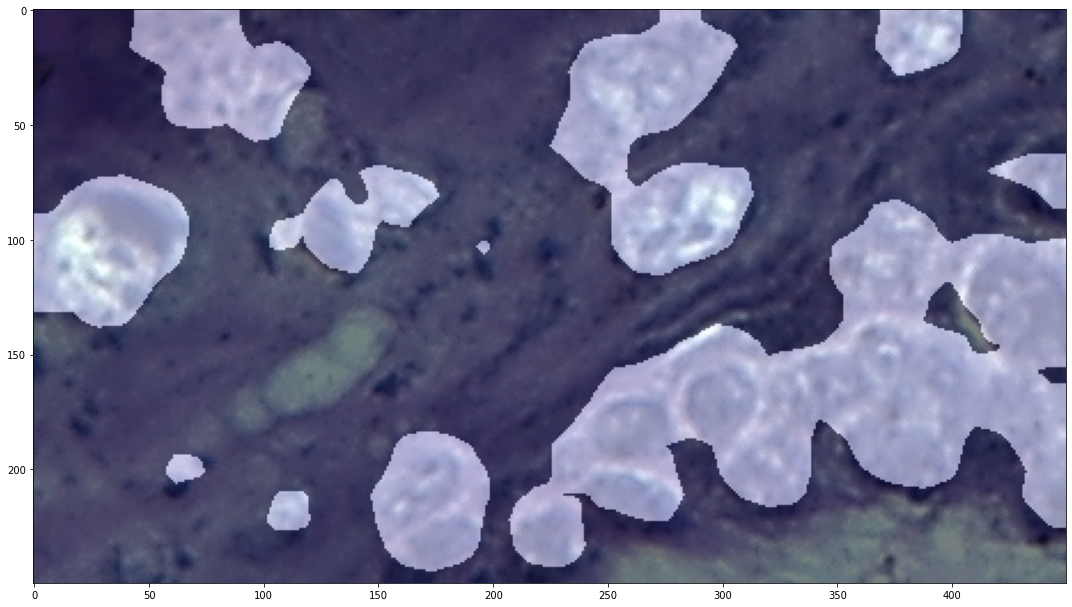

In [16]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

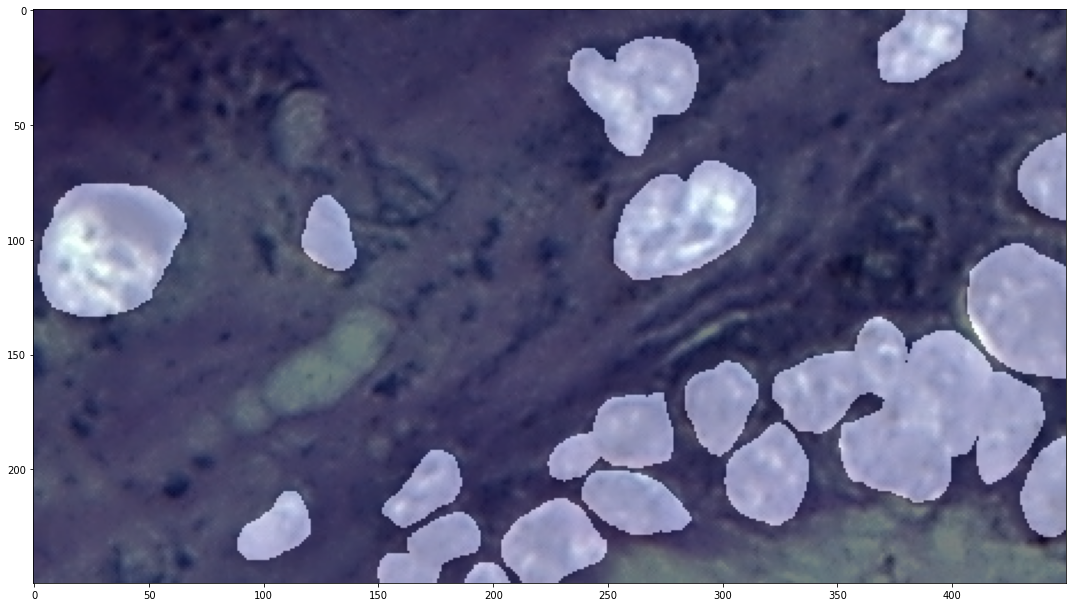

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')
result = mmcv.imread('segmentation/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

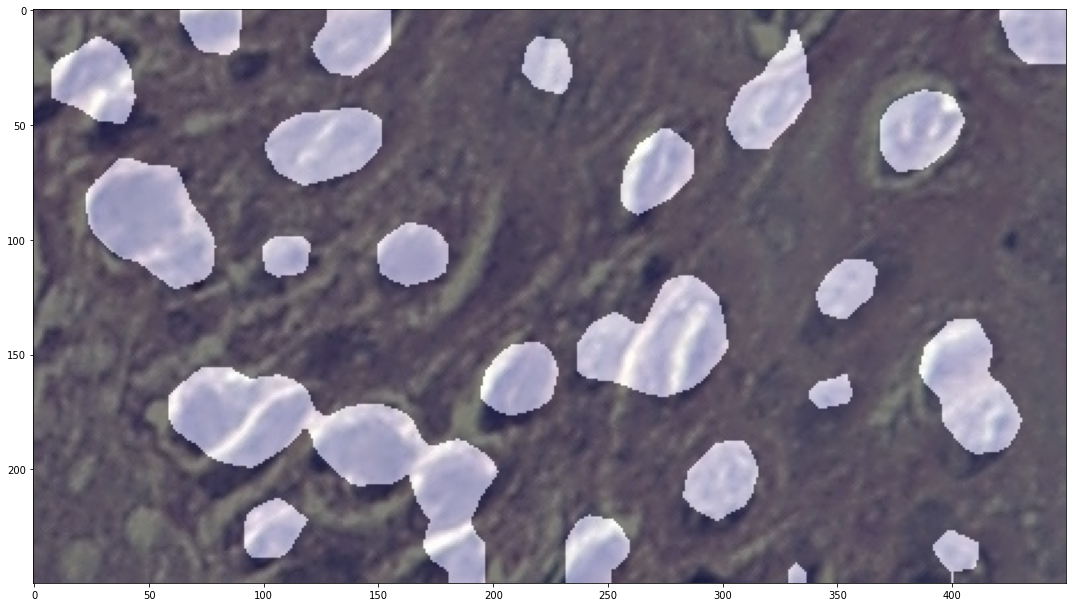

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

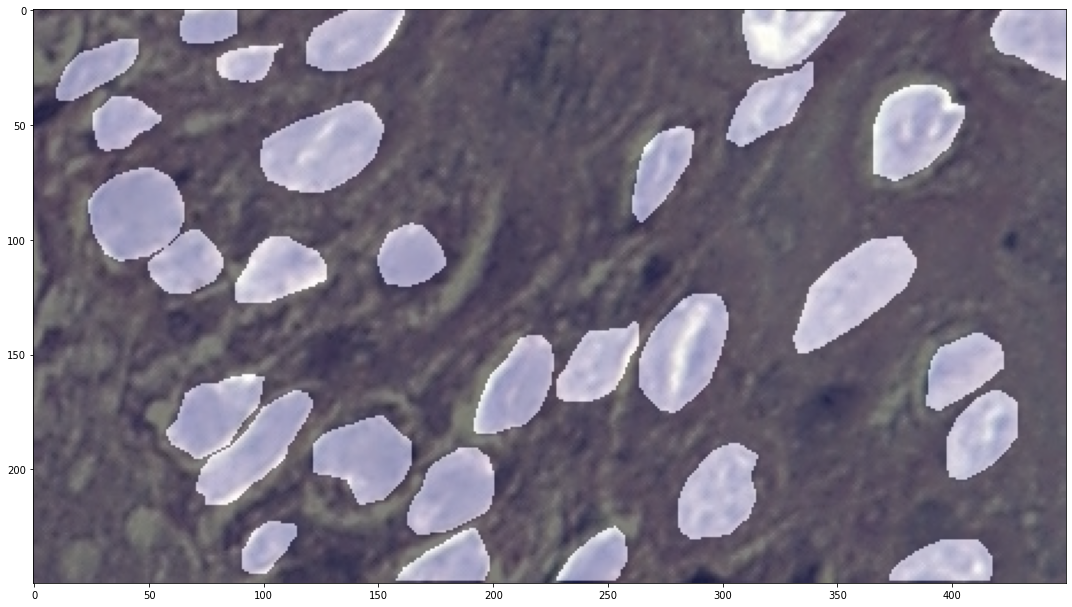

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')
result = mmcv.imread('segmentation/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [20]:
from glob import glob
classes = ['healthy', 'mild', 'moderate', 'severe']
train_images = []
for dysplasia in classes:
    images_glob = glob(f'segmentation/images/{dysplasia}/*')
    for img_path in images_glob:
        img = mmcv.imread(img_path)
        train_images.append((img, f'./work_dirs/psp/result/{dysplasia}' + img_path[20:]))

In [21]:
%rm -rf ./work_dirs/unet/result/

In [22]:
%mkdir ./work_dirs/unet/result/
%mkdir ./work_dirs/unet/result/healthy
%mkdir ./work_dirs/unet/result/mild
%mkdir ./work_dirs/unet/result/moderate
%mkdir ./work_dirs/unet/result/severe

In [23]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path[:-4]}.png', predict_img)

In [24]:
%matplotlib inline
import json

file = open('./work_dirs/psp/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

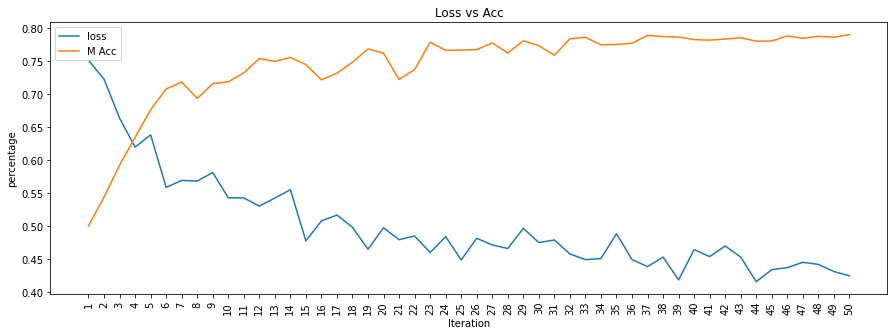

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('Loss_vs_Acc_Graph.png')
plt.show()

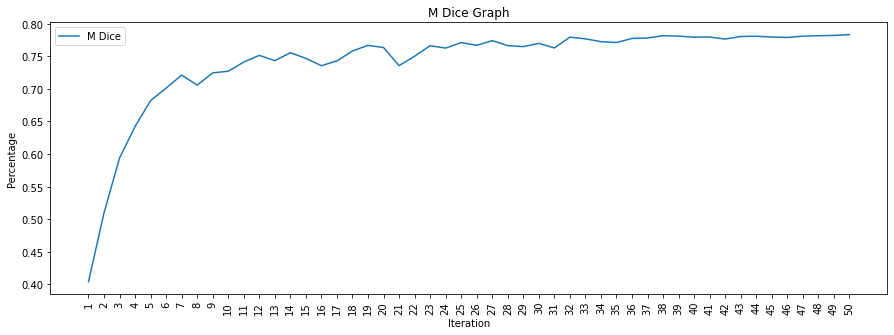

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('M_Dice_Graph.png')
plt.show()
plt.close()

In [27]:
from zipfile import ZipFile

with ZipFile('pspnet.zip', 'w') as zipObj2:
  images_glob = glob('./work_dirs/psp/*')

  for img_path in images_glob:
    zipObj2.write(img_path)